Text(0.5, 0, 'Time (s)')

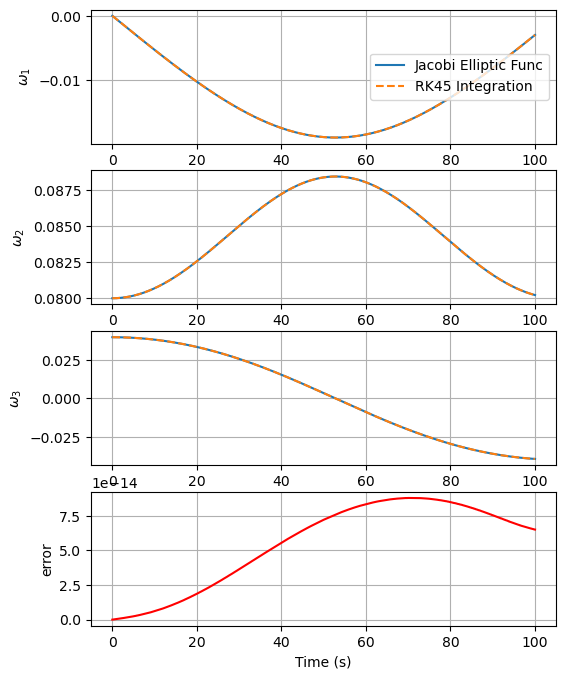

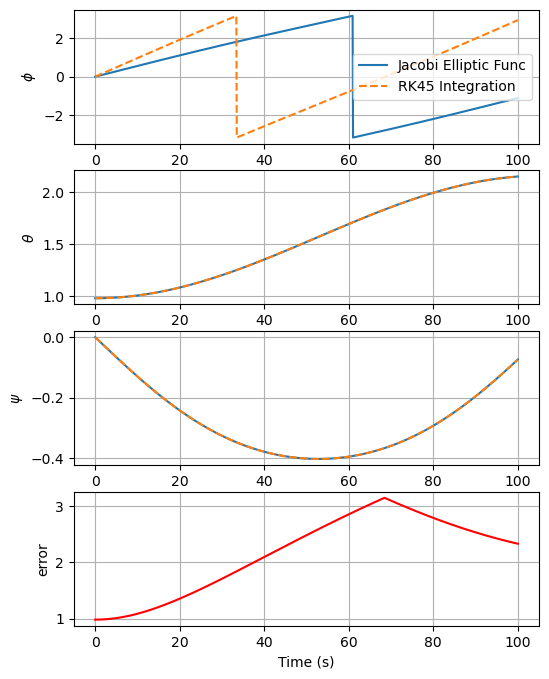

In [82]:
import gtsam
import mpmath
import numpy as np
import scipy
import matplotlib.pyplot as plt
from math_function import *

I_1 = 0.03
I_2 = 0.015
I_3 = 0.02

J = np.diag([I_1, I_2, I_3])

def newtonEuler(t, omega):
  w_1 = omega[0]
  w_2 = omega[1]
  w_3 = omega[2]

  omega_dot = np.array([0.0,0.0,0.0])
  omega_dot[0] = - (I_3 - I_2)/I_1*w_2*w_3
  omega_dot[1] = - (I_1 - I_3)/I_2*w_3*w_1
  omega_dot[2] =   (I_1 - I_2)/I_3*w_1*w_2
  
  return omega_dot


def comptuteRotationMatrix(phi,theta,psi):
  
  # according to Goldstein, Classical Mechanics p.153
  # 3-1-3 sequence rotation, from world to body
  R1 = gtsam.Rot3.Rz(-phi)
  R2 = gtsam.Rot3.Rx(-theta)
  R3 = gtsam.Rot3.Rz(-psi)
  
  R_GI = R3.compose(R2.compose(R1))
  
  return R_GI.inverse()


def computeEulerAngles(R_IG):
  
  R_mat = R_IG.inverse().matrix()
  r13 = R_mat[0][2]
  r23 = R_mat[1][2]
  r33 = R_mat[2][2]
  r31 = R_mat[2][0]
  r32 = R_mat[2][1]
  
  psi = np.arctan2(r13,r23)
  theta = np.arccos(r33)
  phi = np.arctan2(r31,-r32)
  
  return np.array([phi,theta,psi])


def wrap_angle(angle, period=2 * np.pi):
    """Wraps an angle within the range [-period/2, period/2)."""
    return np.arctan2(np.sin(angle), np.cos(angle))

w_1_0 = 0.0
w_2_0 = 0.08
w_3_0 = 0.04

k = w_3_0*np.sqrt( I_3*(I_1 - I_3) / (I_2*(I_1 - I_2)*w_2_0**2 + I_3*(I_1 - I_3)*w_3_0**2) )
A = w_3_0*np.sqrt( I_3*(I_3 - I_2) / (I_1*(I_1 - I_2)) )
b = np.sqrt(  (I_3 - I_2) * ( I_2*(I_1 - I_2)*w_2_0**2 + I_3*(I_1 - I_3)*w_3_0**2 ) / (I_1*I_2*I_3) )

B = w_2_0/np.sqrt(1.0 - k*k)
C = w_3_0


T = 0.5*(I_1*w_1_0**2 + I_2*w_2_0**2 + I_3*w_3_0**2)

L = np.sqrt(I_1**2*w_1_0**2 + I_2**2*w_2_0**2 + I_3**2*w_3_0**2)

m = k*k
K = scipy.special.ellipk(m)

nb_pnts = 1001
t_span = 500.0
t_vec = np.linspace(0,t_span, nb_pnts)

omega = np.zeros((nb_pnts,3))
ea = np.zeros((nb_pnts,3))
R = []
for i in range(len(t_vec)):
  u = b*t_vec[i] + K
  sn, cn, dn, _= scipy.special.ellipj(u,m)
  # sn = mpmath.ellipfun('sn', u, k*k)
  # dn = mpmath.ellipfun('dn', u, k*k)
  # cn = mpmath.ellipfun('cn', u, k*k)
  #dn = np.sqrt(1 - k*k*sn*sn)
  omega[i][0] = A*cn
  omega[i][1] = B*dn
  omega[i][2] = C*sn
  
  _, _, _, am = scipy.special.ellipj(b*t_vec[i],m)
  theta = np.arccos(I_3*omega[i][2]/L)
  psi = np.arctan(I_1*omega[i][0] / (I_2*omega[i][1]))
  pi = mpmath.ellippi((I_3**2)*(C**2)/(L**2), am,m)
  phi = L*t_vec[i]/I_3 + (L**2 - 2*I_3*T)*pi/(I_3*b*L)
  
  ea[i][0] = phi
  ea[i][1] = theta
  ea[i][2] = psi
  R.append(comptuteRotationMatrix(phi,theta,psi))




omega_check, R_check = solve_ne_equation(nb_pnts,t_span/(nb_pnts-1),omega[0], R[0].matrix(), J)

errors_omega = omega - omega_check

error_norms_omega = np.linalg.norm(errors_omega, axis=1)

errors_R = np.zeros((nb_pnts,3))

ea_check = np.zeros((nb_pnts,3))

for i in range(nb_pnts):
  errors_R[i] = R_check[i].Logmap(R[i])
  ea_check[i] = computeEulerAngles(R_check[i])

error_norms_R = np.linalg.norm(errors_R, axis=1)


fig1, ((ax11, ax12, ax13, ax14)) = plt.subplots(nrows=4, ncols=1, figsize=(6, 8))

ax11.plot(t_vec,omega[:,0])
ax11.plot(t_vec,omega_check[:,0], linestyle='--')

ax11.set_ylabel(r'$\omega_1$')
ax11.grid(True)
ax11.legend(["Jacobi Elliptic Func","RK45 Integration"], loc='right')

ax12.plot(t_vec,omega[:,1])
ax12.plot(t_vec,omega_check[:,1], linestyle='--')

ax12.set_ylabel(r'$\omega_2$')
ax12.grid(True)

ax13.plot(t_vec,omega[:,2])
ax13.plot(t_vec,omega_check[:,2], linestyle='--')

ax13.set_ylabel(r'$\omega_3$')
ax13.grid(True)


ax14.plot(t_vec,error_norms_omega, color='r')
ax14.set_ylabel(r'error')
ax14.grid(True)
ax14.set_xlabel("Time (s)")


fig2, ((ax21, ax22, ax23, ax24)) = plt.subplots(nrows=4, ncols=1, figsize=(6, 8))

ax21.plot(t_vec,wrap_angle(ea[:,0]))
ax21.plot(t_vec,ea_check[:,0], linestyle='--')
ax21.set_ylabel(r'$\phi$')
ax21.grid(True)
ax21.legend(["Jacobi Elliptic Func","RK45 Integration"],loc='right')

ax22.plot(t_vec,ea[:,1])
ax22.plot(t_vec,ea_check[:,1], linestyle='--')
ax22.set_ylabel(r'$\theta$')
ax22.grid(True)

ax23.plot(t_vec,ea[:,2])
ax23.plot(t_vec,ea_check[:,2], linestyle='--')
ax23.set_ylabel(r'$\psi$')
ax23.grid(True)

ax24.plot(t_vec,error_norms_R, color='r')
ax24.set_ylabel(r'error')
ax24.grid(True)

ax24.set_xlabel("Time (s)")
